# Prediction Test 利用神经网络建立模型进行股票预测

## 导入必要的库

In [1]:

from math import sin
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import math                                           

from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam          #导入神经网络必要的库

from joblib import dump, load

## 定义几个有用的函数

In [2]:
# 准备训练数据
def getTrain(stock,train_ratio=0.5,validation_ratio=0.2,features=range(0,4)):
    stock.dropna()
    x=stock.iloc[:-1,features].values
    y=stock["close"].values[1:].reshape(-1,1)

    x_scalar=preprocessing.StandardScaler()
    y_scalar=preprocessing.StandardScaler()

    train_ends=math.floor(x.shape[0]*train_ratio)
    validation_ends=train_ends+1+math.floor(x.shape[0]*validation_ratio)

    x_train=x_scalar.fit_transform(x[0:train_ends,:])
    y_train=y_scalar.fit_transform(y[0:train_ends]).reshape(-1)

    x_validation=x_scalar.transform(x[train_ends:validation_ends,:])
    y_validation=y_scalar.transform(y[train_ends:validation_ends]).reshape(-1)

    x_test=x_scalar.transform(x[validation_ends:,:])
    y_test=y_scalar.transform(y[validation_ends:]).reshape(-1)
    return x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar


In [3]:
# 为训练切分时间序列
def slice_time_series(x,y,win_size):
    x_sliced=[]
    y_sliced=[]
    for t in range(len(x)-win_size):
        x_sliced.append(x[t:t+win_size])
        y_sliced.append(y[t+win_size-1])
    x_sliced=np.array(x_sliced)
    y_sliced=np.array(y_sliced)
    return x_sliced.reshape((-1,win_size,feature_size)),y_sliced


In [4]:
# 建立模型
def build_model(win_size,feature_size,hiden=20):
    i=Input(shape=(win_size,feature_size))
    x=LSTM(hiden)(i)
    x=Dense(1)(x)
    model=Model(i,x)
    model.compile(loss='mse',optimizer=Adam(lr=0.01))
    return model

In [5]:
# 用于预测未来股票数据的函数
def multi_step_predict(model,data,N=1,feature_size=1):
    y_hat=[]
    x_test_last=data
    for i in range(N):
        y_hat_s1=model.predict(x_test_last.reshape(1,-1,feature_size))[0,0]
        x_test_last=np.roll(x_test_last,-1)
        x_test_last[-1]=y_hat_s1
        y_hat.append(y_hat_s1)
    return y_hat

## 获取2018.7.1之前的一个时间段的数据

                  open        high         low       close       volume  \
date                                                                      
1999-11-10   29.500000   29.800000   27.000000   27.750000  174085100.0   
1999-11-11   27.580000   28.380000   27.530000   27.710000   29403500.0   
1999-11-12   27.860000   28.300000   27.770000   28.050000   15008000.0   
1999-11-15   28.200000   28.250000   27.700000   27.750000   11921100.0   
1999-11-16   27.880000   27.970000   26.480000   26.550000   23223100.0   
...                ...         ...         ...         ...          ...   
2020-08-12  140.727884  142.203582  140.325422  141.666965   43268629.0   
2020-08-13  142.203582  142.337736  140.862039  140.996193   25798477.0   
2020-08-14  141.264502  142.203582  140.593730  142.069428   37584530.0   
2020-08-17  142.069428  147.301446  141.801119  145.423286   98742699.0   
2020-08-18  145.557440  145.557440  142.606045  143.410971   54091961.0   

            outstanding_

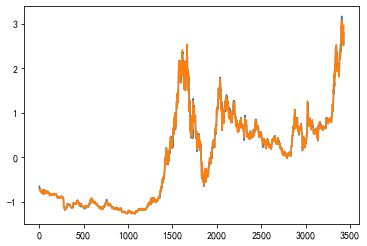

In [6]:
stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600000", adjust="hfq")  # 利用 AkShare 获取浦发银行的后复权数据

print(stock_hfq_df)                 #观察获取的数据
stock_hfq_df=stock_hfq_df.drop(stock_hfq_df.loc[stock_hfq_df.index.year==2001].index).first('19Y')  #取2018.7.1之前的一个时间段的数据
print(stock_hfq_df)                 #观察截取后的数据

x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar=getTrain(
    stock_hfq_df,train_ratio=0.85,validation_ratio=0.1,features=range(0,4))

plt.plot(x_train[:,0])
plt.plot(y_train[:])


## 建立模型

In [ ]:
# 对获取的数据进行分割
win_size=50
feature_size=x_train.shape[1]
x_train,y_train=slice_time_series(x_train,y_train,win_size)
x_validation,y_validation=slice_time_series(x_validation,y_validation,win_size)
x_test,y_test=slice_time_series(x_test,y_test,win_size)

# 建立模型以便于训练
model=build_model(win_size,feature_size,hiden=30)

#进行训练
result=model.fit(x_train,y_train,
    batch_size=100,
    epochs=30,
    validation_data=(x_validation,y_validation))

# 绘制loss曲线
plt.plot(result.history['loss'],label="loss")
plt.plot(result.history['val_loss'],label="val_loss")
plt.legend()
# 进行一步预测
y_hat=model.predict(x_test)
plt.plot(y_test,label='true')
plt.plot(y_hat,label='prediction')

plt.legend()

# 计算mase
mase=np.sum(np.abs(y_hat[1:].reshape(-1)-y_test[1:]))/np.sum(np.abs(y_test[:-1]-y_test[1:]))
print(mase)

# 模型检测
true_up=((y_test[1:]-y_test[:-1])>0)
pred_up=((y_hat[:-1,0]-y_test[:-1])>0)
correct=(true_up==pred_up)
acc=np.sum(true_up==pred_up)/len(true_up)
print(acc)

# 进行多步预测
y_hat=multi_step_predict(model,x_test[0],N=100,feature_size=feature_size)

plt.plot(y_test,label='true')
plt.plot(y_hat,label='prediction')
plt.legend()

start=56
ndays=5
y_hat=multi_step_predict(model,x_test[start],N=ndays,feature_size=feature_size)

plt.plot(y_test[start:start+ndays],label='true')
plt.plot(y_hat,label='prediction')
plt.legend()

# 存储模型
model.save('stock_model.mod')
dump(x_scalar, 'x_scaler.bin', compress=True)
dump(y_scalar, 'y_scaler.bin', compress=True)

